In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
from datetime import datetime

from tqdm.notebook import tqdm

import pandas as pd

In [2]:
df = pd.read_csv('municipality_bus_utilization.csv')

### Processing the data

In [158]:
test_data_start = pd.to_datetime('2017-08-7')#'2017-08-05'
test_data_end = pd.to_datetime('2017-08-19')

train_data_start=pd.to_datetime('2017-06-05')

df['timestamp'] = pd.to_datetime(df['timestamp'])
# Filter the dataframe based on the date range
test_data = df[(df['timestamp'] >= test_data_start)]
print('Test Dataset',len(test_data))
display(test_data)

train_data = df[(df['timestamp'] < test_data_start) & (df['timestamp'] > train_data_start)]
print('Train Dataset',len(train_data))
display(train_data)

Test Dataset 2320


,timestamp,municipality_id,usage,total_capacity
10750,2017-08-07 07:59:16,1,223,397
10751,2017-08-07 07:59:16,4,1352,3893
10752,2017-08-07 07:59:16,2,271,697
10753,2017-08-07 07:59:16,3,655,1930
10754,2017-08-07 07:59:16,7,686,2019
...,...,...,...,...
13065,2017-08-19 16:30:35,2,548,697
13066,2017-08-19 16:30:35,8,1193,2947
13067,2017-08-19 16:30:35,7,1354,2019
13068,2017-08-19 16:30:35,6,1680,3113


Train Dataset 10570


,timestamp,municipality_id,usage,total_capacity
180,2017-06-05 07:57:17,5,63,587
181,2017-06-05 07:57:17,9,462,1332
182,2017-06-05 07:57:17,1,155,397
183,2017-06-05 07:57:17,2,291,697
184,2017-06-05 07:57:17,4,1113,3893
...,...,...,...,...
10745,2017-08-06 16:29:16,6,868,3113
10746,2017-08-06 16:29:16,7,1111,2019
10747,2017-08-06 16:29:16,0,500,2813
10748,2017-08-06 16:29:16,9,623,1332


## Creating new dataset with better inputs
<br>1_ Each week has its own id
<br>2_ Each day of the week its own id
<br>3_ Time variable (hours and minutes) converted into single variable (hour*60+minute)

In [160]:
def create_dataframe(df):
    new_dataframe=[]
    first_day=False
    for row in df.iloc:
        time=row['timestamp']
        time_tuple=time.timetuple()
        #HOUR
        main_time = time.timetuple()[3]*60+time.timetuple()[4]
        #Week
        dt =time - datetime(*train_data_start.timetuple()[:3])
        week=int(dt.days/7)
        new_dataframe.append({
            "week":int(week),"week_day":int(time.weekday()),"time":int(main_time),
            "mid":int(row['municipality_id']),
            "usage":int(row['usage']),"capacity":int(row['total_capacity'])
        }) 
    return pd.DataFrame(new_dataframe)


train_df = create_dataframe(train_data)
test_df = create_dataframe(test_data)
print("Train Dataset",len(train_df))
display(train_df)
print("Test Dataset",len(test_df))
display(test_df)

Train Dataset 10570


,week,week_day,time,mid,usage,capacity
0,0,0,477,5,63,587
1,0,0,477,9,462,1332
2,0,0,477,1,155,397
3,0,0,477,2,291,697
4,0,0,477,4,1113,3893
...,...,...,...,...,...,...
10565,8,6,989,6,868,3113
10566,8,6,989,7,1111,2019
10567,8,6,989,0,500,2813
10568,8,6,989,9,623,1332


Test Dataset 2320


,week,week_day,time,mid,usage,capacity
0,9,0,479,1,223,397
1,9,0,479,4,1352,3893
2,9,0,479,2,271,697
3,9,0,479,3,655,1930
4,9,0,479,7,686,2019
...,...,...,...,...,...,...
2315,10,5,990,2,548,697
2316,10,5,990,8,1193,2947
2317,10,5,990,7,1354,2019
2318,10,5,990,6,1680,3113


## Creating Pytorch Dataset

In [165]:
class DFDataset(Dataset):
    def __init__(self, dataframe):
        self.df=dataframe
        print('DFDataset: ',len(self.df))
        
    def __len__(self):
        #return len(self.file_list)
        return len(self.df)
    
    def get_week(self,week_id):
        sample = self.df[self.df['week']==week_id]
        lst_in=[]
        lst_out=[]
        for row in sample.iloc:
            i=[row['week'],row['week_day'],row['time'],row['mid']]
            o=[row['usage'] ]
            lst_in.append(i)
            lst_out.append(o)
        
        lst_in=torch.Tensor(lst_in).float()
        lst_out=torch.Tensor(lst_out).float()
        return  lst_in,lst_out
        

    def __getitem__(self, index):
        sample = self.df.iloc[index]
        i=[sample['week'],sample['week_day'],sample['time'],sample['mid']]
        o=[sample['usage'] ]
        i=torch.Tensor(i).float()
        o=torch.Tensor(o).float()
        return  i,o

## Simple NN Model

In [153]:
class NNModel(nn.Module):
    def __init__(self):
        super(NNModel, self).__init__()
        
        self.seq = nn.Sequential(
            nn.Linear(4, 10),
            nn.LeakyReLU(),
            nn.Linear(10,1)
        )
    
    def forward(self, x):
        
        return self.seq(x)

## Training

In [162]:
batch_size=64
train_dataset = DFDataset(train_df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset=DFDataset(test_df)



DFDataset:  13070
DFDataset:  13070


In [168]:
net = NNModel()
net.train()
lr=0.001
num_epochs=20
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)#optim.Adam(net.parameters(), lr=0.001)

losses=[]
for epoch in tqdm(range(num_epochs)):
    for i_data,o_data in train_loader:
        optimizer.zero_grad()
        ai_out = net(i_data)
        loss = criterion(ai_out, o_data)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
    #print(f"Epoch {epoch+1}/{num_epochs}, Last_Loss: {loss.item():.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

## Ploting the loss 

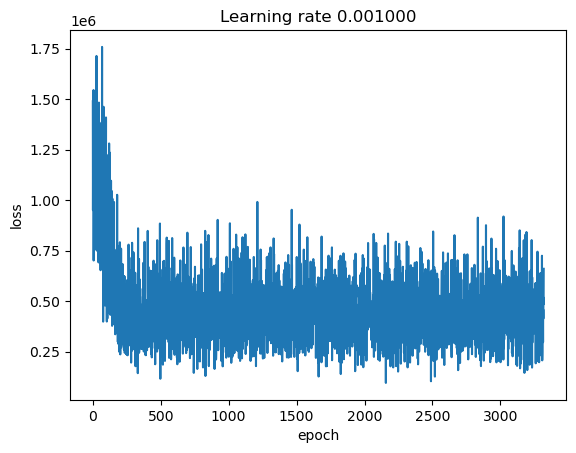

In [169]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(lr))
plt.show()


## Result
<br>NN model couldnt learned as we expected. But atleast i wanted to try and see the results, probably RNN model would work more suitable. I didnt created dataframe to see predictions, we can easly notice in here that accuracy is not good enough

In [171]:
net.eval()
with torch.no_grad():
    inp,outp=test_dataset.get_week(9)
    predict = net(inp)
    display(predict)
    display(outp)
    display(inp)

tensor([[ 552.5672],
        [ 571.2911],
        [ 558.8085],
        ...,
        [1165.5984],
        [1109.4265],
        [1159.3569]])

tensor([[ 223.],
        [1352.],
        [ 271.],
        ...,
        [ 667.],
        [ 464.],
        [1113.]])

tensor([[  9.,   0., 479.,   1.],
        [  9.,   0., 479.,   4.],
        [  9.,   0., 479.,   2.],
        ...,
        [  9.,   6., 989.,   9.],
        [  9.,   6., 989.,   0.],
        [  9.,   6., 989.,   8.]])